(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic

# Import project package
import AutoEncode
import AutoEncode.diffgeo.NeuralGeodesics as NG

# Import libraries to handel data
import CSV
import DataFrames as DF
import Glob

# Import ML libraries
import Flux

# Import library to save models
import JLD2

# Import basic math
import LinearAlgebra
import StatsBase
import Random
Random.seed!(42)

# Import Plotting libraries
using CairoMakie
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set Plotting style
Antibiotic.viz.theme_makie!()

`[explanation here]`

Let's begin by loading the data.

In [2]:
# Define data directory
data_dir = "$(git_root())/data/Iwasawa_2022"

# Load file into memory
df_ic50 = CSV.read("$(data_dir)/iwasawa_ic50_tidy.csv", DF.DataFrame)

# Locate strains with missing values
missing_strains = unique(df_ic50[ismissing.(df_ic50.log2ic50), :strain])

# Remove data
df_ic50 = df_ic50[[x ∉ missing_strains for x in df_ic50.strain], :]

# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract unique drugs to make sure the matrix is built correctly
drug = sort(unique(df_ic50.drug))

# Initialize matrix to save ic50 values
ic50_mat = Matrix{Float32}(undef, length(drug), length(df_group))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :drug)
    # Check that the stress are in the correct order
    if all(data.drug .== drug)
        # Add data to matrix
        ic50_mat[:, i] = Float32.(data.log2ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Define number of environments
n_env = size(ic50_mat, 1)
# Define number of samples
n_samples = size(ic50_mat, 2)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment
dt = StatsBase.fit(StatsBase.ZScoreTransform, ic50_mat, dims=2)

# Center data to have mean zero and standard deviation one
ic50_std = StatsBase.transform(dt, ic50_mat)

8×1269 Matrix{Float32}:
 -0.549695  -0.636041  -0.645549  …  -0.52737   -0.567254  -0.489156
  0.127085   0.396026   0.422921      0.152449   0.106901   0.0836802
 -0.952641  -0.814063  -0.947413     -0.712676  -0.723125  -0.706011
  0.434811  -0.480968  -0.244397      0.702219   0.484944   0.544966
 -0.469319  -0.463574  -0.461562     -0.450975  -0.278867  -0.296857
  0.689883   0.638487   0.126388  …   0.910045   0.774161   0.968758
  0.22606    0.13382    0.396659     -0.436597  -0.589569  -0.649776
 -0.605906  -0.748028  -0.533354     -0.860089  -1.17661   -0.934113

Next, let's load the RHVAE model and the trained weights.

In [3]:
# Define temp
T = 0.5f0

# Define model directory
model_dir = "$(git_root())/code/processing/" *
            "beta-rhvae_jointlogencoder_simpledecoder_iwasawa_fitness/v02/" *
            "output"

# Load model template
rhvae = JLD2.load("$(model_dir)/model.jld2")["model"]

rhvae = AutoEncode.RHVAEs.RHVAE(
    deepcopy(rhvae.vae),
    deepcopy(rhvae.metric_chain),
    deepcopy(rhvae.centroids_data),
    deepcopy(rhvae.centroids_latent),
    deepcopy(rhvae.L),
    deepcopy(rhvae.M),
    T,
    deepcopy(rhvae.λ)
)

# List files in output directory
files = sort(
    Glob.glob("$(model_dir)/model_state/*$(T)temp*.jld2"[2:end], "/")
)

# Load the MSE for each epoch
mse_epoch = [JLD2.load(files[i])["mse_train"] for i in 1:length(files)]

# Load parameters
model_state = JLD2.load(files[end])["model_state"]

# Set model parameters
Flux.loadmodel!(rhvae, model_state)
# Update metric
AutoEncode.RHVAEs.update_metric!(rhvae)

typeof(rhvae)

AutoEncode.RHVAEs.RHVAE{AutoEncode.VAEs.VAE{AutoEncode.JointLogEncoder, AutoEncode.SimpleDecoder}}

Let's extract these latent space representations and append the corresponding
metadata.

In [4]:
# Map data to latent space
latent = rhvae.vae.encoder(ic50_std).µ

# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract strains as ordered in ic50 matrix
strains_mat = [x.strain for x in keys(df_group)]
day_mat = [x.day for x in keys(df_group)]

# Initialize empty dataframe
df_latent = DF.DataFrame(
    strain=strains_mat,
    day=day_mat,
    z1=latent[1, :],
    z2=latent[2, :],
)

# Add corresponding metadata resistance value
df_latent = DF.leftjoin!(
    df_latent,
    unique(df_ic50[:, [:strain, :day, :parent, :env]]),
    on=[:strain, :day]
)

first(df_latent, 5)

5×6 DataFrame
 Row │ strain           day    z1         z2         parent   env     
     │ String31         Int64  Float32    Float32    String7  String7 
─────┼────────────────────────────────────────────────────────────────
   1 │ Parent in TET 1      1  -0.173435  -0.090122  Parent   TET
   2 │ Parent in TET 1      2  -0.354907  -0.241639  Parent   TET
   3 │ Parent in TET 1      3  -0.400168  -0.407077  Parent   TET
   4 │ Parent in TET 1      4  -0.520361  -0.574409  Parent   TET
   5 │ Parent in TET 1      5  -0.54061   -0.219141  Parent   TET

Next, to properly visualize the latent space, let's compute the fitness
landscape for each drug as well as the metric.

In [6]:
# Define number of points per axis
n_points = 300

# Define range of latent space
latent_range_z1 = Float32.(range(-3.2, 3.2, length=n_points))
latent_range_z2 = Float32.(range(-3.5, 3, length=n_points))

# Define latent points to evaluate
z_mat = reduce(hcat, [[x, y] for x in latent_range_z1, y in latent_range_z2])

# Compute inverse metric tensor
ic50_rhvae = reshape(rhvae.vae.decoder(z_mat).µ', n_points, n_points, n_env)

# Compute inverse metric tensor
Ginv = AutoEncode.RHVAEs.G_inv(z_mat, rhvae)

# Compute log determinant of metric tensor
logdetG = reshape(-1 / 2 * AutoEncode.utils.slogdet(Ginv), n_points, n_points);

Let's visualize the fitness landscapes for each antibiotic and the metric as a
heatmap.

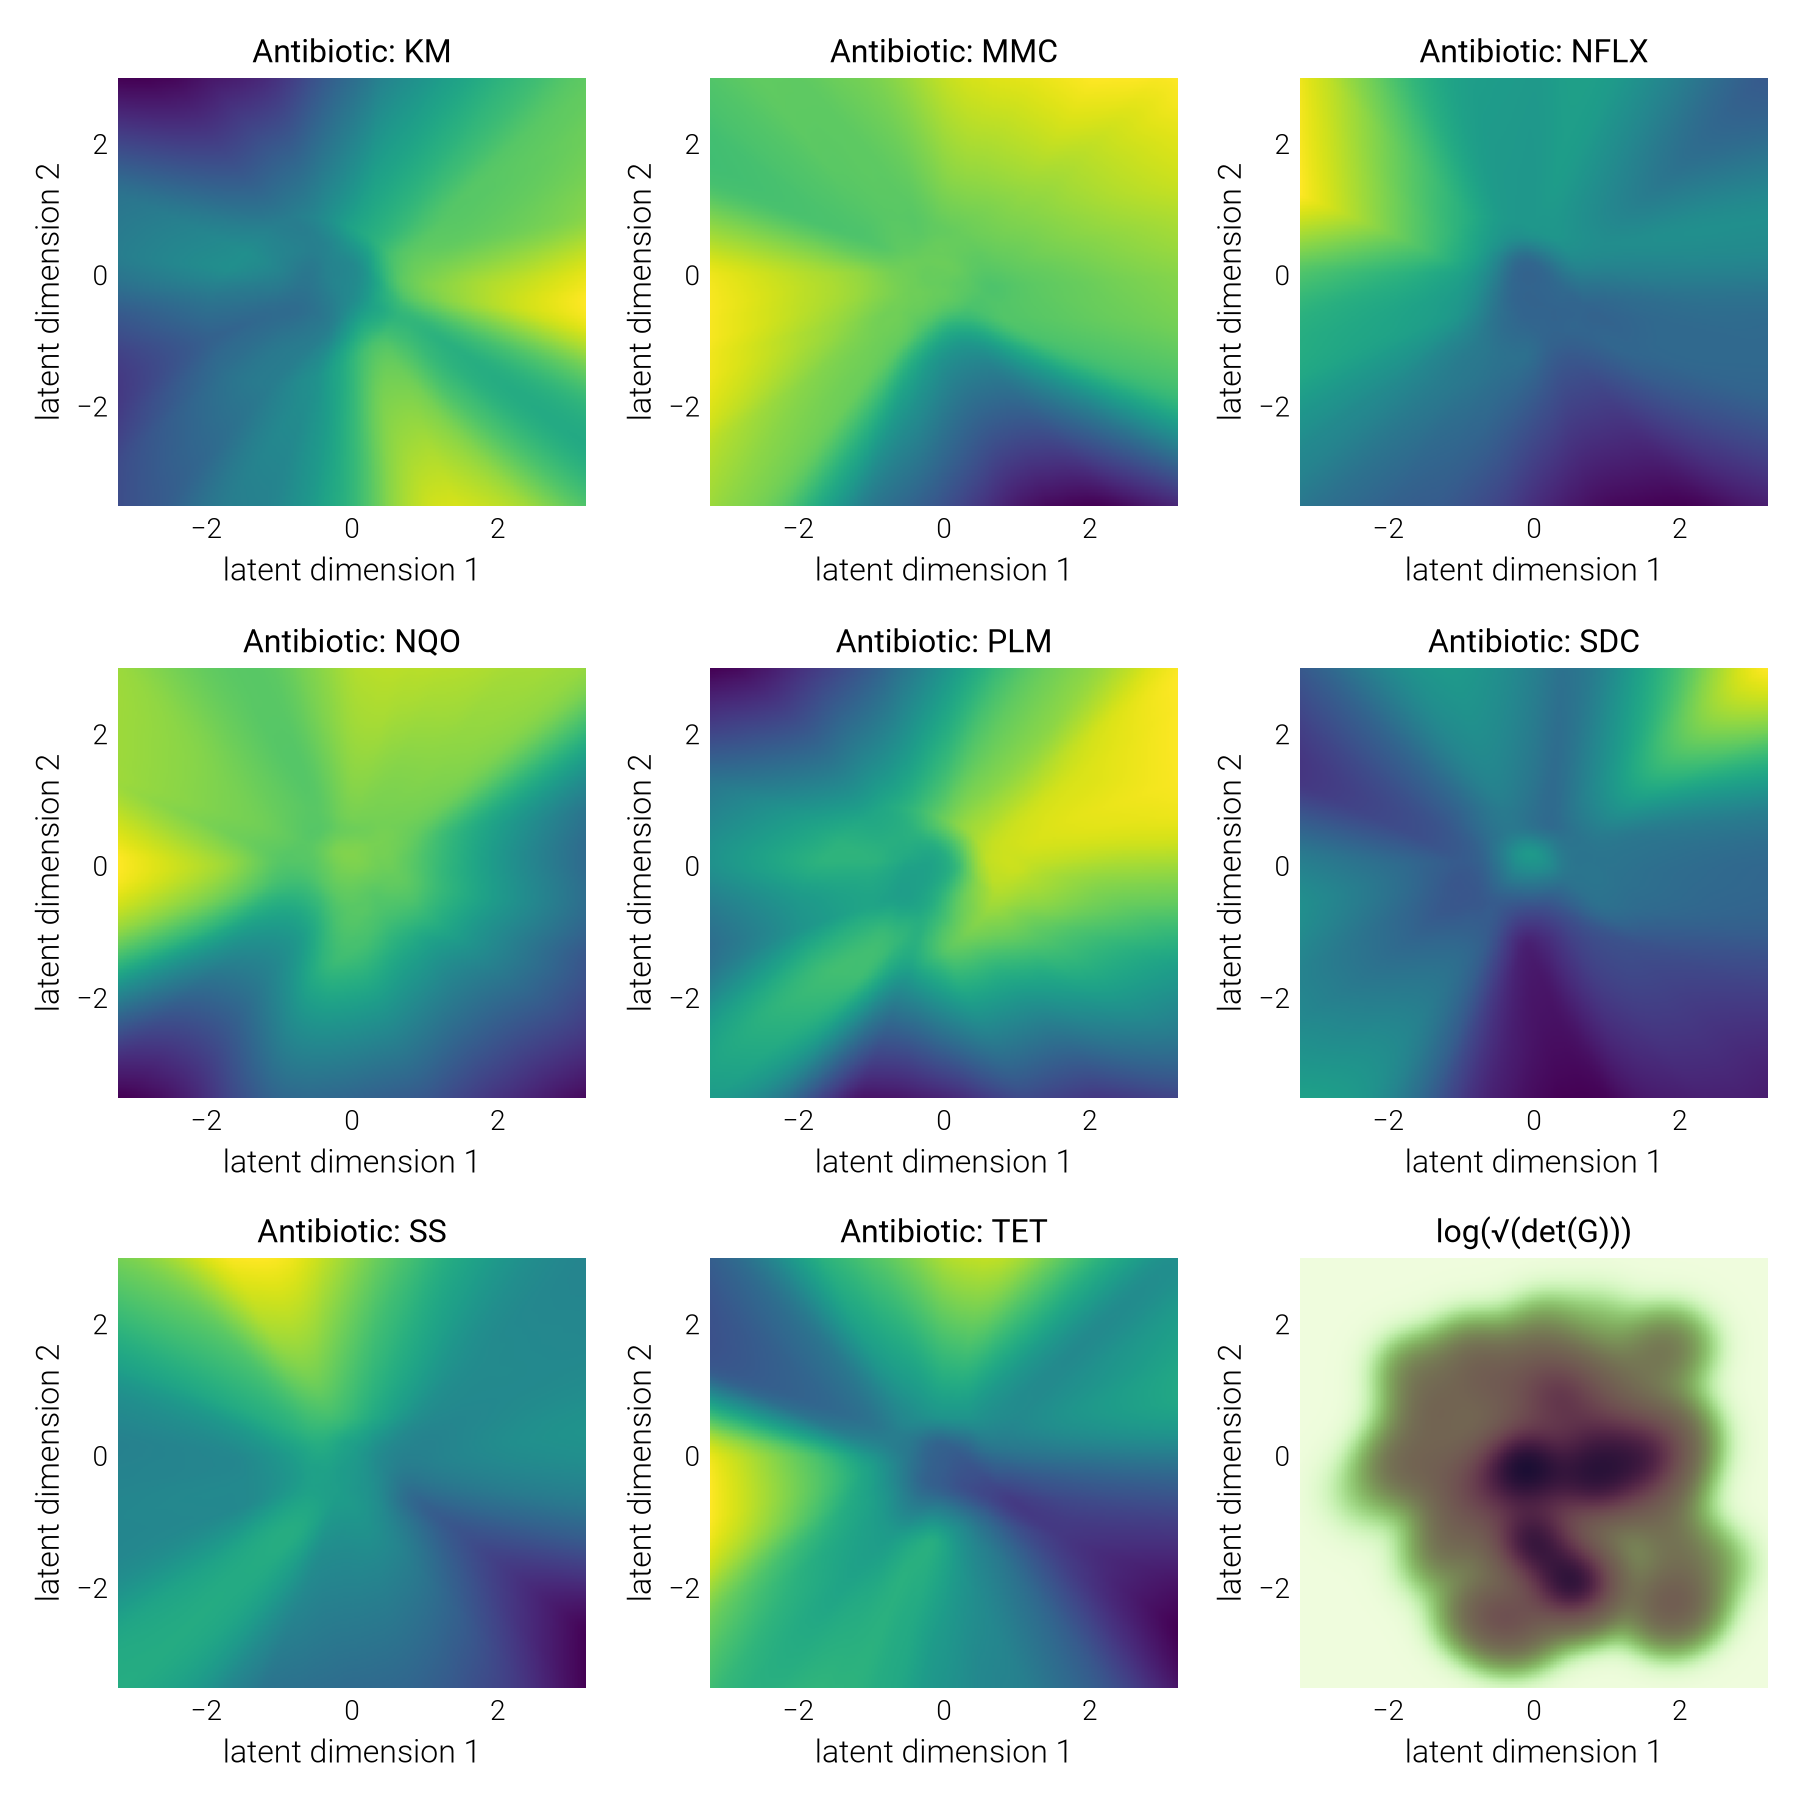

In [7]:
# Initialize plot
fig = Figure(size=(900, 900))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through environments
for (i, fit_landscape) in enumerate(eachslice(ic50_rhvae, dims=3))
    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add axis to plot
    ax = Axis(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(
        ax,
        latent_range_z1,
        latent_range_z2,
        fit_landscape,
        colormap=:viridis
    )

    # Set subplot title
    ax.title = "Antibiotic: $(drug[i])"
end # for

# Add extra axis to plot
ax = Axis(
    fig[3, 3],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    title="log(√(det(G)))",
)

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range_z1, latent_range_z2, logdetG, colormap=:tokyo)

fig

In this form, the fitness landscapes extrapolate outside the data manifold.
LEt's use the metric to delimite the data manifold over the landscape.

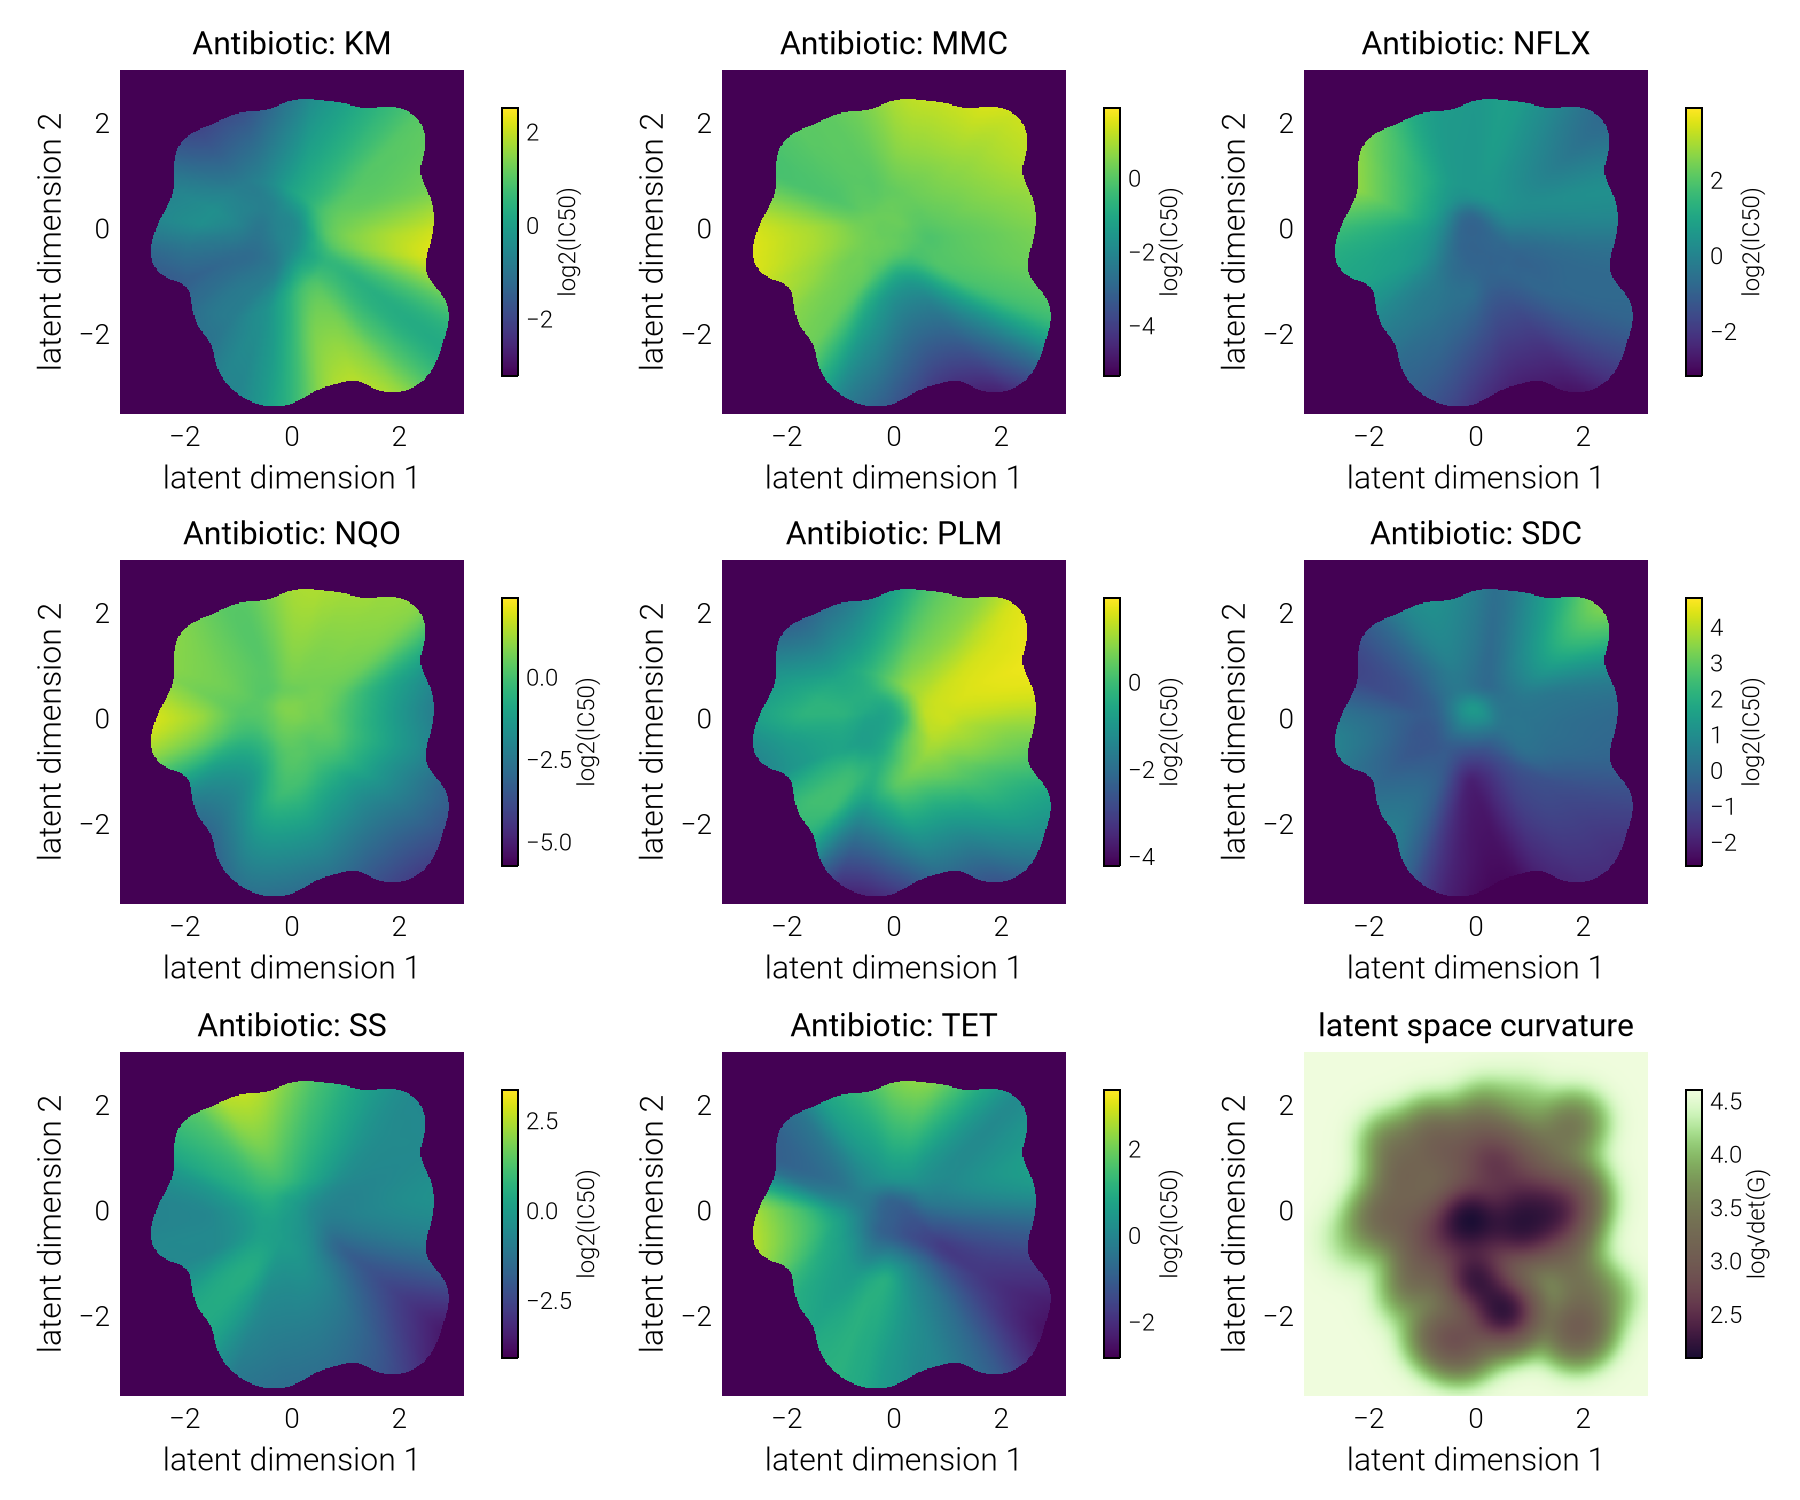

In [18]:
# Define mask for fitness landscape
mask = (maximum(logdetG) * 0.92 .< logdetG .<= maximum(logdetG))

# Initialize plot
fig = Figure(size=(900, 750))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through environments
for (i, fit_landscape) in enumerate(eachslice(ic50_rhvae, dims=3))
    # Mask fitness landscape
    fit_landscape_masked = (mask .* minimum(fit_landscape)) .+
                           (fit_landscape .* .!mask)

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add GridLayout to insert axis
    gl = fig[row, col] = GridLayout()
    # Add axis to plot
    ax = Axis(
        gl[1:10, 1],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
        aspect=AxisAspect(1),
    )
    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(
        ax,
        latent_range_z1,
        latent_range_z2,
        fit_landscape_masked,
        colormap=:viridis,
        colorrange=(
            minimum(fit_landscape), maximum(fit_landscape)
        ),
    )

    # Add colorbar
    cb = Colorbar(
        gl[2:9, 2],
        hm,
        size=8,
        label="log2(IC50)",
        labelsize=12,
        labelpadding=0.0,
        ticklabelsize=12,
        ticksvisible=false
    )

    # Set subplot title
    ax.title = "Antibiotic: $(drug[i])"
end # for

# Add extra GridLayout to insert axis
gl = fig[3, 3] = GridLayout()

# Add extra axis to plot
ax = Axis(
    gl[1:10, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    title="latent space curvature",
    aspect=AxisAspect(1),
)

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range_z1, latent_range_z2, logdetG, colormap=:tokyo)
# Add colorbar
cb = Colorbar(
    gl[2:9, 2],
    hm,
    size=8,
    label="log√det(G)",
    labelsize=12,
    labelpadding=0.0,
    ticklabelsize=12,
    ticksvisible=false
)

save("/Users/mrazo/Downloads/fig.pdf", fig)

fig

Let's now get a 3D view of the latent space.

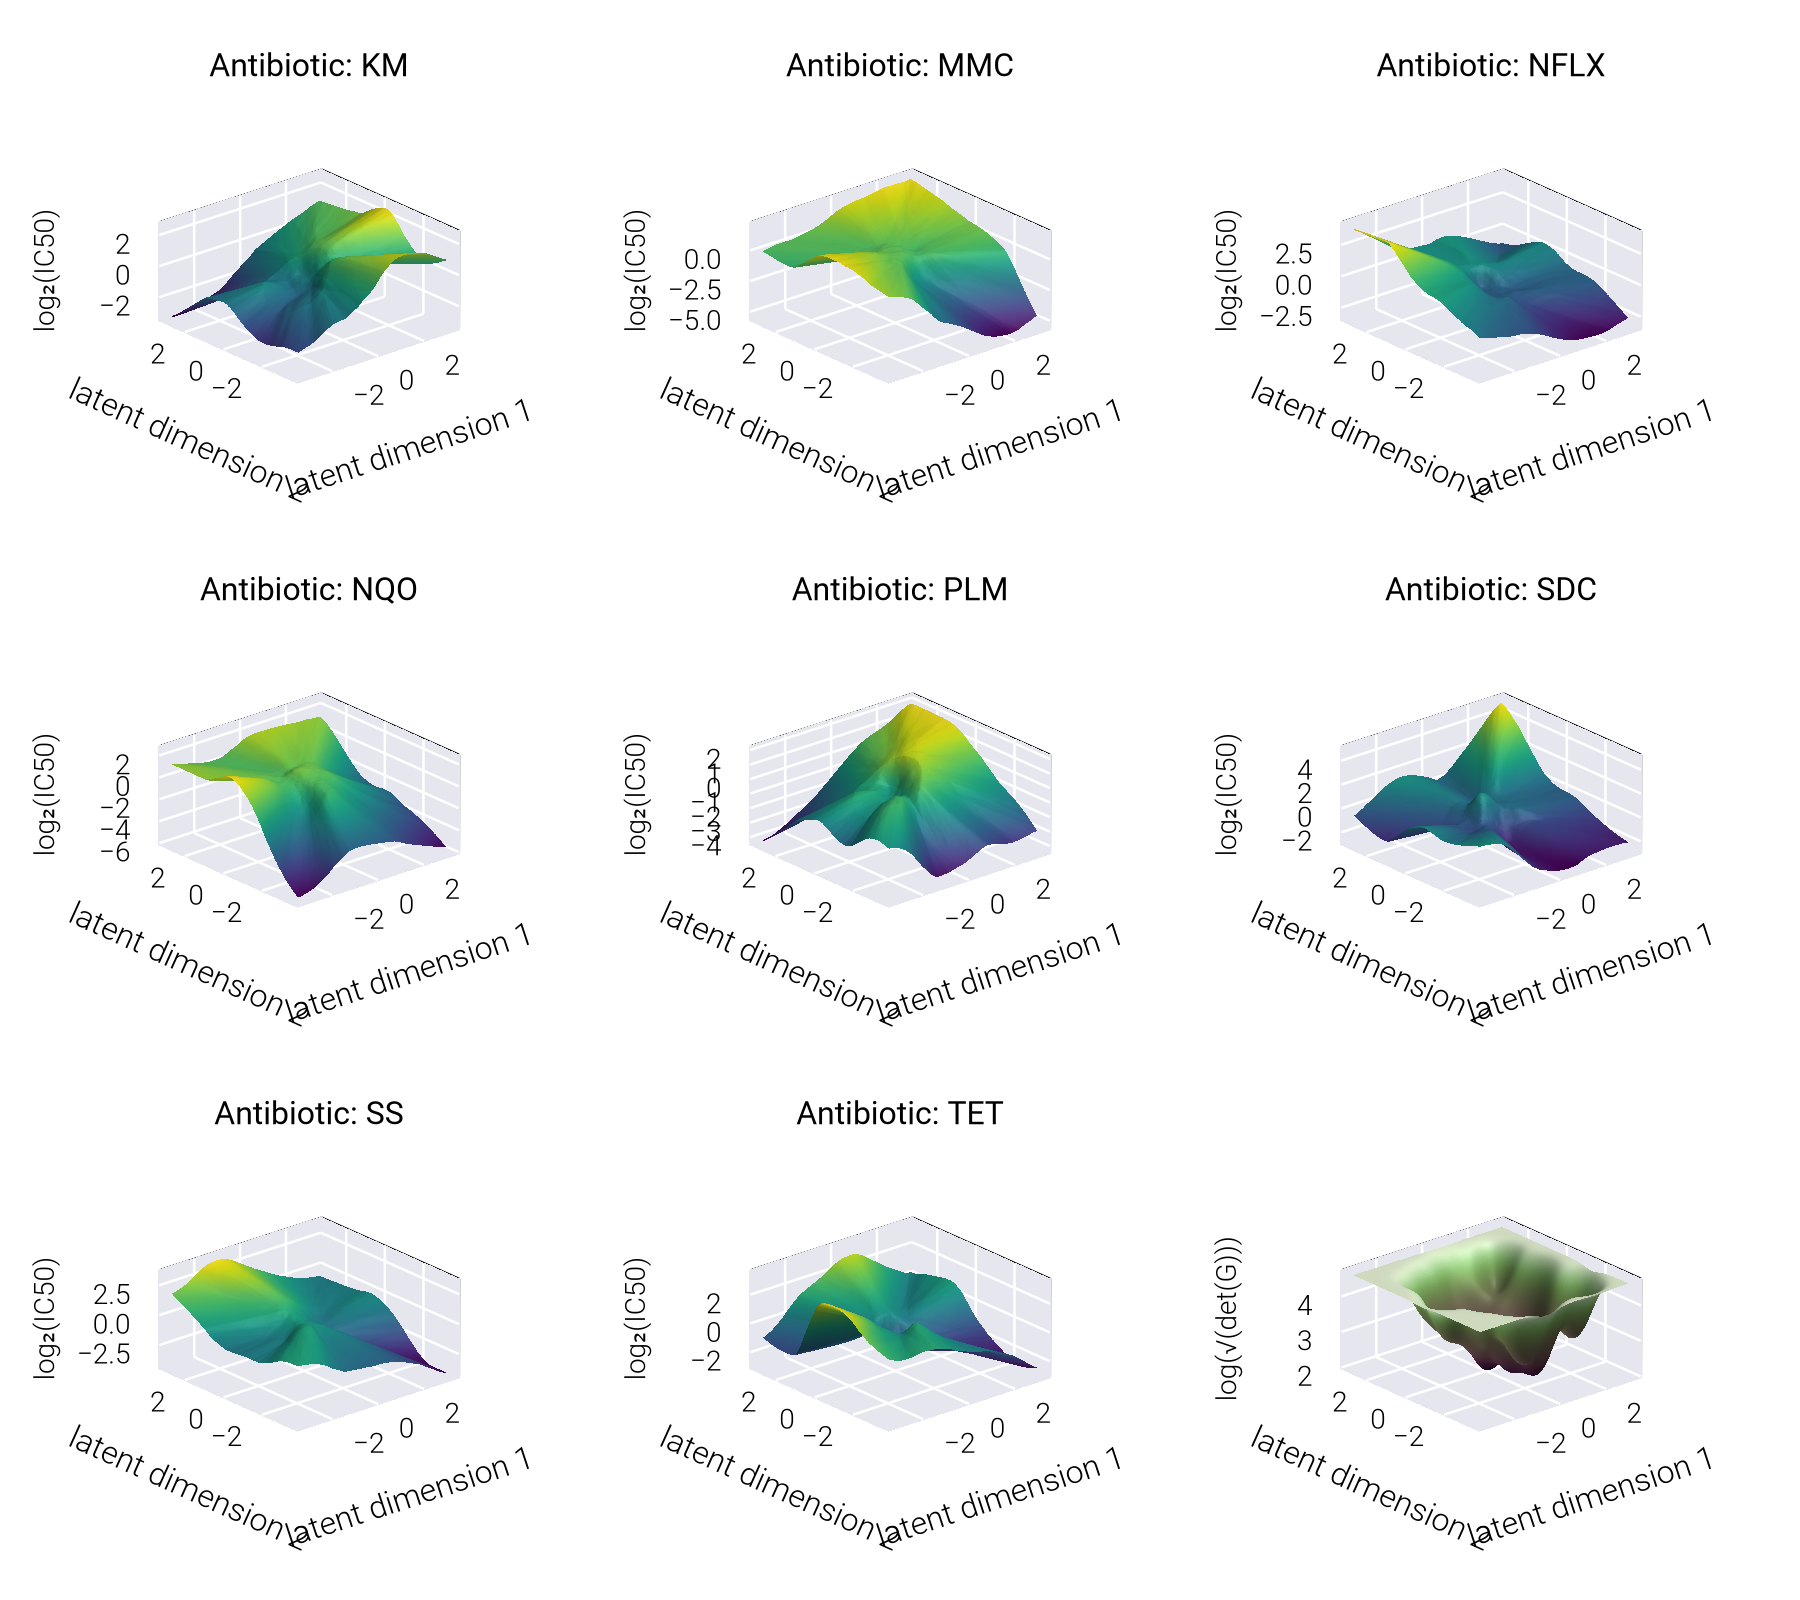

In [20]:
# Initialize plot
fig = Figure(size=(900, 800))

# Define the number of rows and columns
rows = 3
cols = 3

# Loop through environments
for (i, fit_landscape) in enumerate(eachslice(ic50_rhvae, dims=3))
    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add 3D axis to plot
    ax = Axis3(
        fig[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
        zlabel="log₂(IC50)",
        title="Antibiotic: $(drug[i])",
        xypanelcolor="#E6E6EF",
        xzpanelcolor="#E6E6EF",
        yzpanelcolor="#E6E6EF",
        xgridcolor=:white,
        ygridcolor=:white,
        zgridcolor=:white,
        aspect=(1, 1, 0.5)
    )

    # Plot fit landscape as surface
    surface!(
        ax,
        latent_range_z1,
        latent_range_z2,
        fit_landscape,
        colormap=:viridis
    )

end # for

# Add extra axis to plot
ax = Axis3(
    fig[3, 3],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    zlabel="log(√(det(G)))",
    xypanelcolor="#E6E6EF",
    xzpanelcolor="#E6E6EF",
    yzpanelcolor="#E6E6EF",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
    aspect=(1, 1, 0.5)
)

# Plot metric tensor determinant as surface
surface!(
    ax,
    latent_range_z1,
    latent_range_z2,
    logdetG,
    colormap=:tokyo
)

fig

Again, let's apply the mask to the latent space to visualize the data manifold.

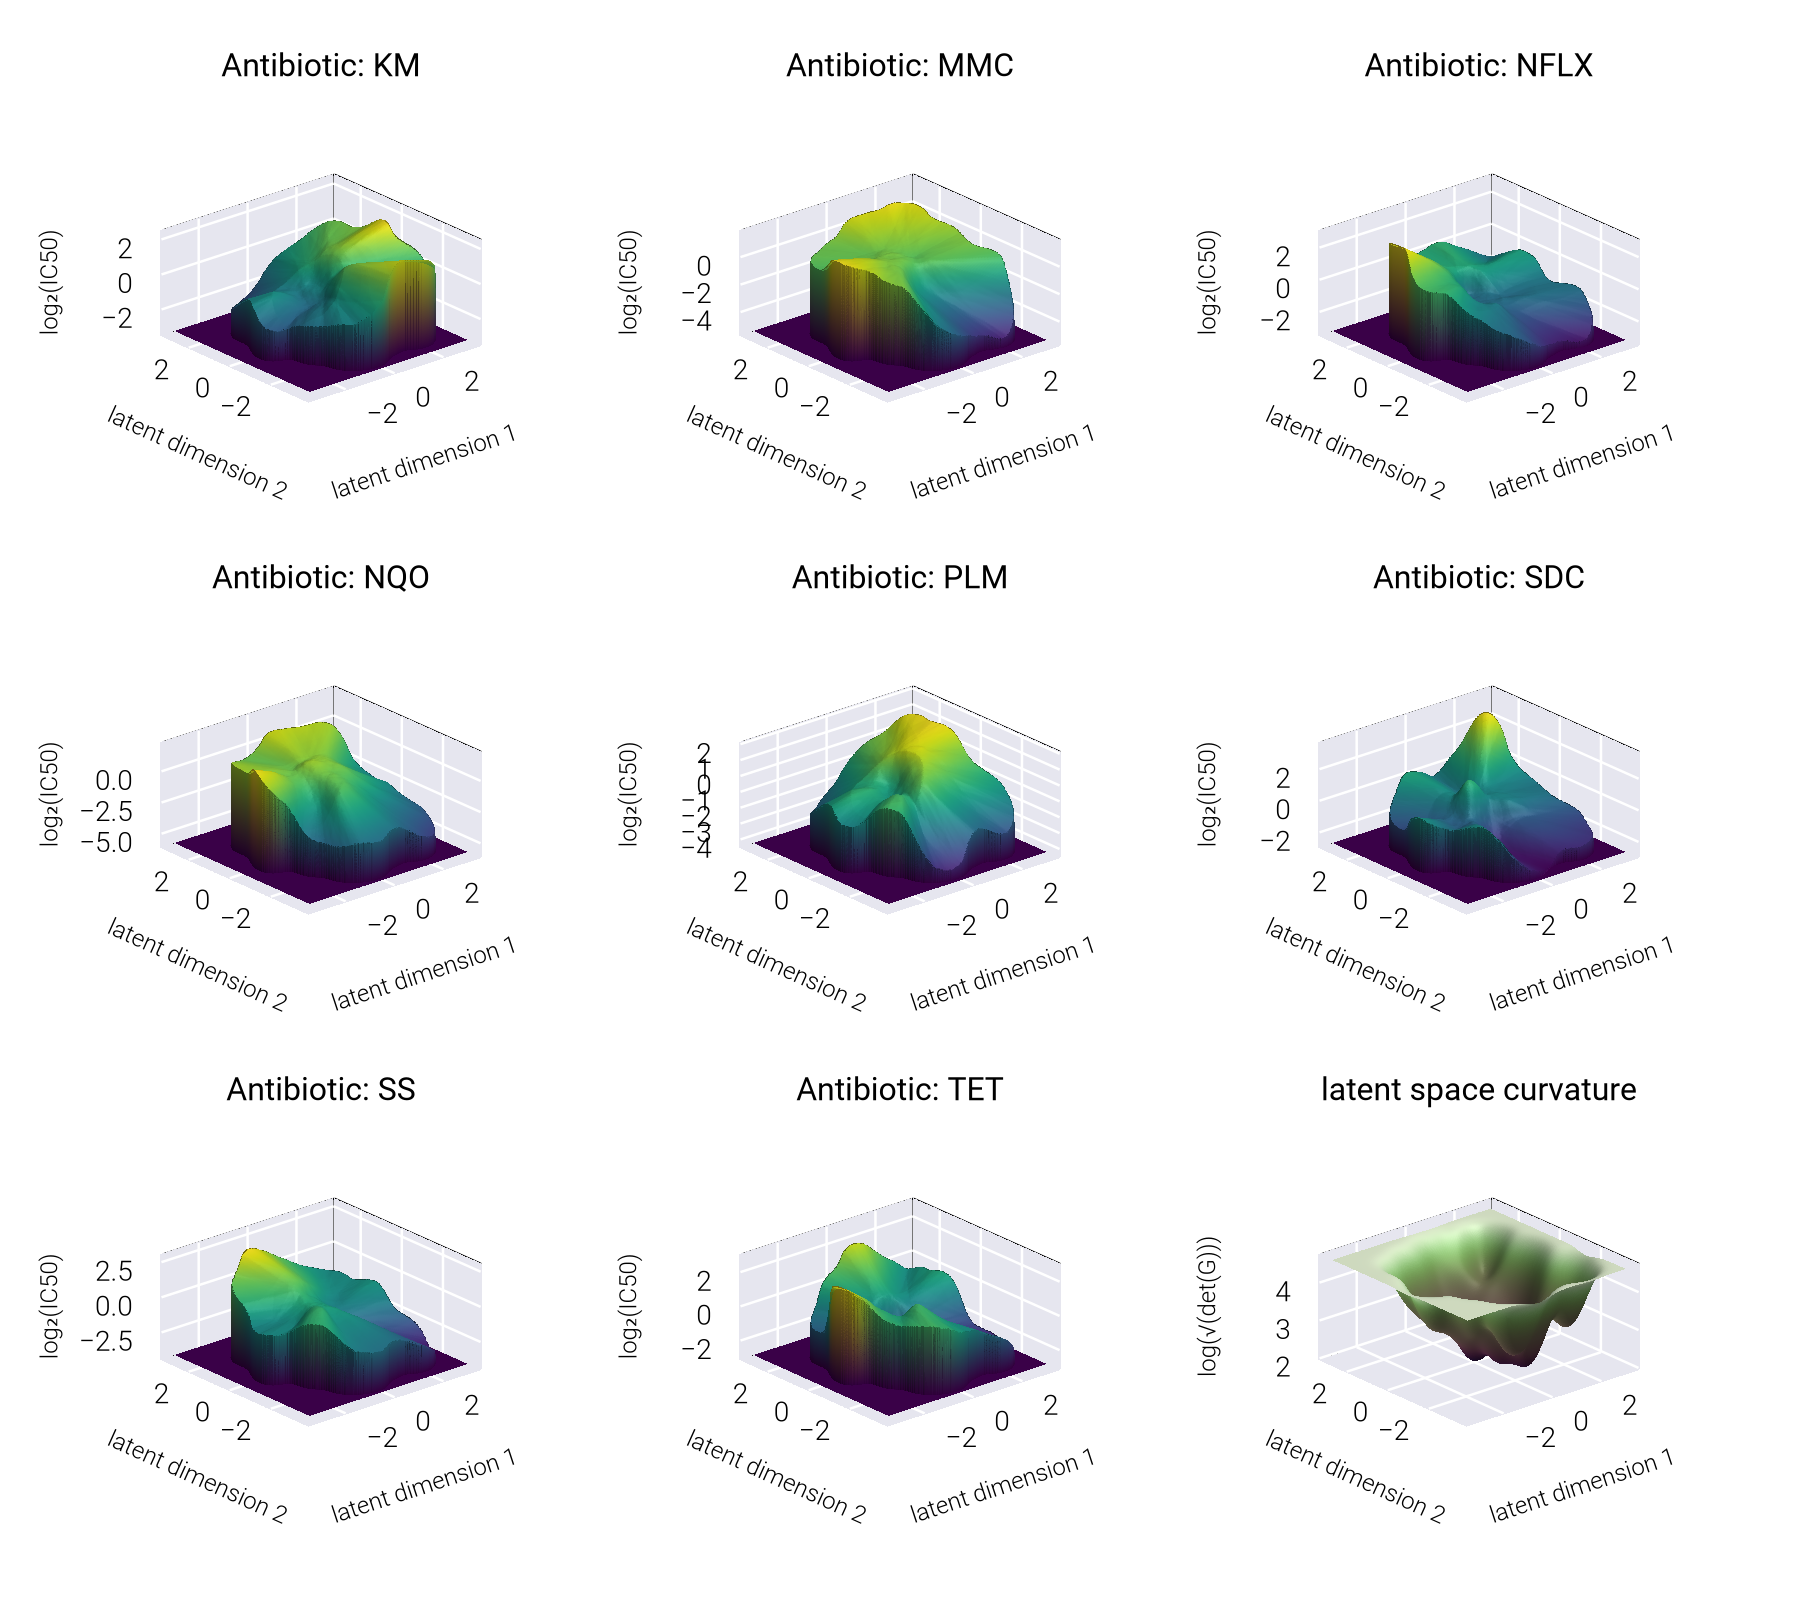

In [29]:
# Initialize plot
fig = Figure(size=(900, 800))

# Define the number of rows and columns
rows = 3
cols = 3

# Add global GridLayout to insert axis
gl_global = fig[1, 1] = GridLayout()

# Loop through environments
for (i, fit_landscape) in enumerate(eachslice(ic50_rhvae, dims=3))
    # Mask fitness landscape
    fit_landscape_masked = (mask .* minimum(fit_landscape)) .+
                           (fit_landscape .* .!mask)

    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add 3D axis to plot
    ax = Axis3(
        gl_global[row, col],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
        zlabel="log₂(IC50)",
        title="Antibiotic: $(drug[i])",
        aspect=(1, 1, 0.5),
        xlabelsize=12,
        ylabelsize=12,
        zlabelsize=12,
    )

    # Plot fit landscape as surface
    surface!(
        ax,
        latent_range_z1,
        latent_range_z2,
        fit_landscape_masked,
        colormap=:viridis
    )
end # for

# Add extra axis to plot
ax = Axis3(
    gl_global[3, 3],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    zlabel="log(√(det(G)))",
    title="latent space curvature",
    aspect=(1, 1, 0.5),
    xlabelsize=12,
    ylabelsize=12,
    zlabelsize=12,
)

# Plot metric tensor determinant as surface
surface!(
    ax,
    latent_range_z1,
    latent_range_z2,
    logdetG,
    colormap=:tokyo
)

# Change colgap and rowgap
colgap!(gl_global, 0)
rowgap!(gl_global, 0)

fig

Let's repeat this plot, but this time, we will add the latent coordinates for
strains evolved in a particular drug.

## `TET`

In [30]:
# Define antibiotic
antibiotic = "TET"

# Extract latent space for antibiotic
df_antibiotic = df_latent[df_latent.env.==antibiotic, :]

# Map latent points to predicted resistance in antibiotic space
ic50_antibiotic = vec(rhvae.vae.decoder(
    Matrix(df_antibiotic[:, [:z1, :z2]])'
).µ[drug.==antibiotic, :])

# Add predicted resistance to dataframe
df_antibiotic[!, :log2ic50] = ic50_antibiotic

first(df_antibiotic, 5)

5×7 DataFrame
 Row │ strain           day    z1         z2         parent   env      log2ic5 ⋯
     │ String31         Int64  Float32    Float32    String7  String7  Float32 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Parent in TET 1      1  -0.173435  -0.090122  Parent   TET      -0.9148 ⋯
   2 │ Parent in TET 1      2  -0.354907  -0.241639  Parent   TET      -0.7054
   3 │ Parent in TET 1      3  -0.400168  -0.407077  Parent   TET      -0.5978
   4 │ Parent in TET 1      4  -0.520361  -0.574409  Parent   TET      -0.2123
   5 │ Parent in TET 1      5  -0.54061   -0.219141  Parent   TET      -0.2895 ⋯
                                                                1 column omitted

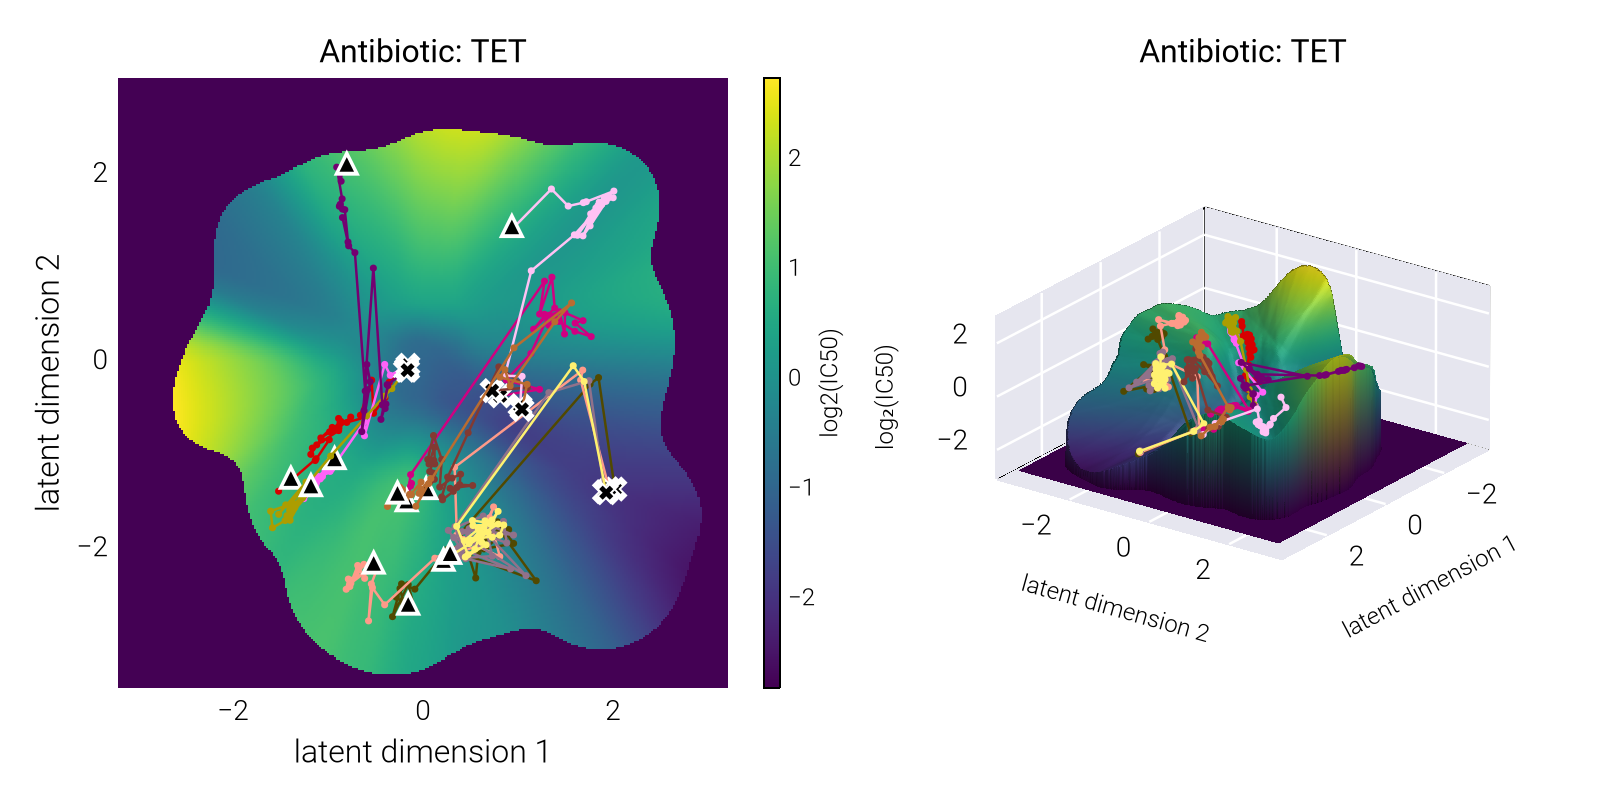

In [45]:
# Initialize figure
fig = Figure(size=(800, 400))

# Add global GridLayout to insert axis
gl = fig[1, 1] = GridLayout()

# Add 2D axis to plot
ax1 = Axis(
    gl[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    title="Antibiotic: $(antibiotic)",
    aspect=AxisAspect(1)
)

# Add 3D axis to plot
ax2 = Axis3(
    gl[1, 3],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    zlabel="log₂(IC50)",
    title="Antibiotic: $(antibiotic)",
    xlabelsize=12,
    ylabelsize=12,
    zlabelsize=12,
    aspect=(1, 1, 0.5),
    azimuth=0.2π,
    protrusions=(30, 10, 30, 20),
)
# Define fitness landscape
fit_landscape = dropdims(ic50_rhvae[:, :, drug.==antibiotic], dims=3)

# Mask fitness landscape
fit_landscape_masked = (mask .* minimum(fit_landscape)) .+
                       (fit_landscape .* .!mask)

# Plot heatmap of predicted resistance
hm = heatmap!(
    ax1,
    latent_range_z1,
    latent_range_z2,
    fit_landscape_masked,
    colormap=:viridis
)

# Add colorbar
cb = Colorbar(
    gl[1, 2],
    hm,
    size=8,
    label="log2(IC50)",
    labelsize=12,
    labelpadding=0.0,
    ticklabelsize=12,
    ticksvisible=false
)

# Plot surface of predicted resistance
surface!(
    ax2,
    latent_range_z1,
    latent_range_z2,
    fit_landscape_masked,
    colormap=:viridis
)

# Group data by strain
df_group = DF.groupby(df_antibiotic, :strain)

# Loop through groups
for (j, data) in enumerate(df_group)
    # Sort data by day
    data = DF.sort!(data, :day)
    # Add scatter plot to axis
    scatterlines!(
        ax1,
        data.z1,
        data.z2,
        markersize=5,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
    )

    # Add scatter plot to 3D axis
    scatterlines!(
        ax2,
        data.z1,
        data.z2,
        data.log2ic50,
        markersize=5,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
    )

    # Add first point 
    scatter!(
        ax1,
        [data.z1[1]],
        [data.z2[1]],
        color=:white,
        markersize=18,
        marker=:xcross
    )
    scatter!(
        ax1,
        [data.z1[1]],
        [data.z2[1]],
        color=:black,
        markersize=10,
        marker=:xcross
    )

    # Add last point
    scatter!(
        ax1,
        [data.z1[end]],
        [data.z2[end]],
        color=:white,
        markersize=18,
        marker=:utriangle
    )
    scatter!(
        ax1,
        [data.z1[end]],
        [data.z2[end]],
        color=:black,
        markersize=10,
        marker=:utriangle
    )
end

save("/Users/mrazo/Downloads/fig.png", fig)
fig

## `KM`

In [58]:
# Define antibiotic
antibiotic = "KM"

# Extract latent space for antibiotic
df_antibiotic = df_latent[df_latent.env.==antibiotic, :]

# Map latent points to predicted resistance in antibiotic space
ic50_antibiotic = vec(rhvae.vae.decoder(
    Matrix(df_antibiotic[:, [:z1, :z2]])'
).µ[drug.==antibiotic, :])

# Add predicted resistance to dataframe
df_antibiotic[!, :log2ic50] = ic50_antibiotic

first(df_antibiotic, 5)

5×7 DataFrame
 Row │ strain          day    z1          z2         parent   env      log2ic5 ⋯
     │ String31        Int64  Float32     Float32    String7  String7  Float32 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Parent in KM 1      1  -0.207901   -0.141944  Parent   KM       -0.6241 ⋯
   2 │ Parent in KM 1      2  -0.0786659  -0.15705   Parent   KM       -0.5646
   3 │ Parent in KM 1      3  -0.124588   -0.224674  Parent   KM       -0.5913
   4 │ Parent in KM 1      4  -0.137898   -0.488862  Parent   KM       -0.5904
   5 │ Parent in KM 1      5   0.0192663  -0.353842  Parent   KM       -0.4455 ⋯
                                                                1 column omitted

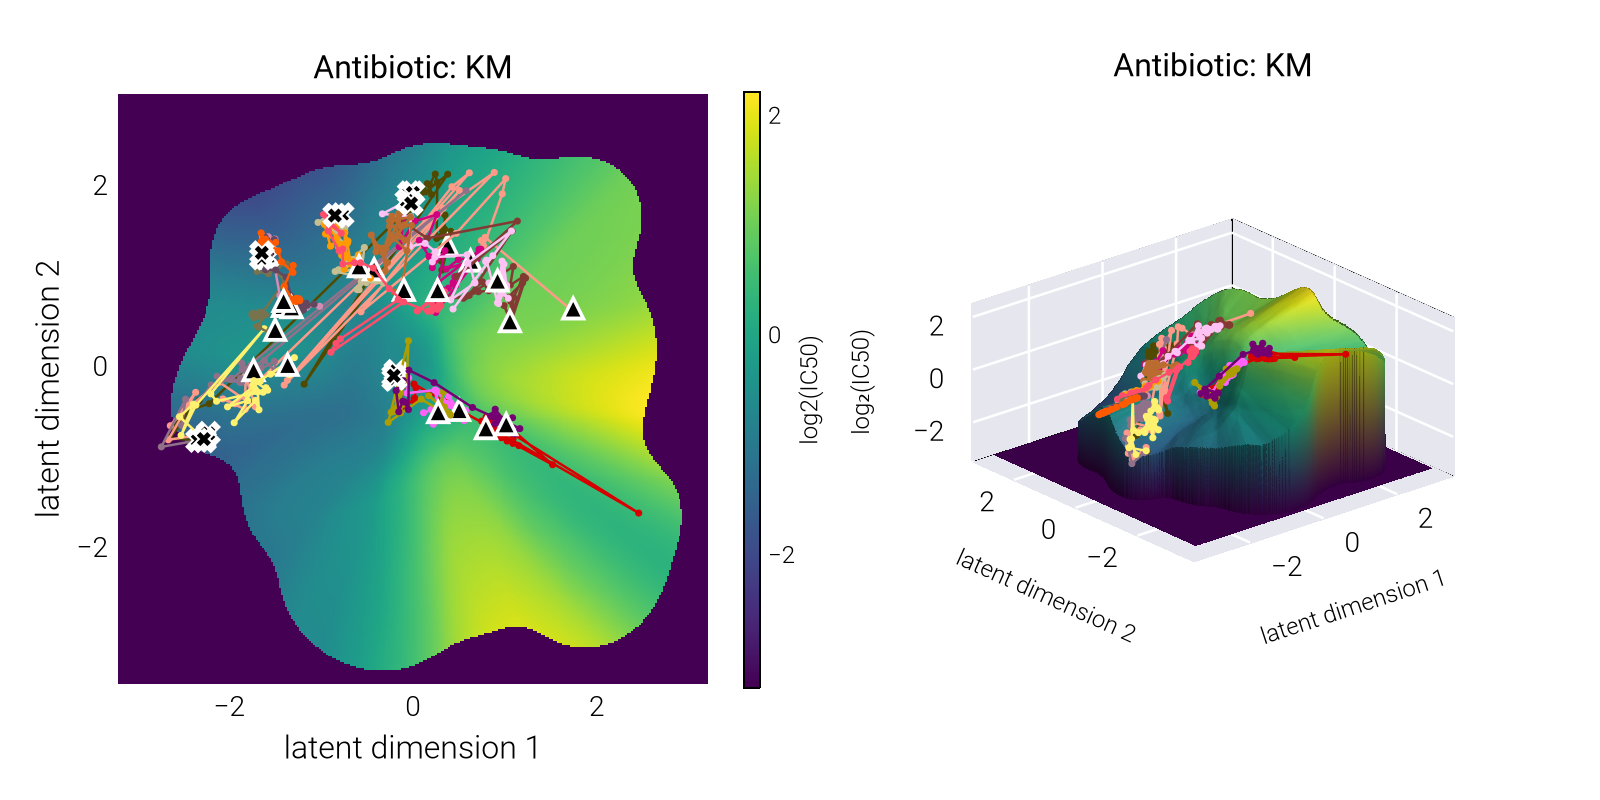

In [60]:
# Initialize figure
fig = Figure(size=(800, 400))

# Add global GridLayout to insert axis
gl = fig[1, 1] = GridLayout()

# Add 2D axis to plot
ax1 = Axis(
    gl[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    title="Antibiotic: $(antibiotic)",
    aspect=AxisAspect(1)
)

# Add 3D axis to plot
ax2 = Axis3(
    gl[1, 3],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    zlabel="log₂(IC50)",
    title="Antibiotic: $(antibiotic)",
    xlabelsize=12,
    ylabelsize=12,
    zlabelsize=12,
    aspect=(1, 1, 0.5),
    # azimuth=0.2π
    # protrusions=(30, 10, 30, 20),
)

# Define fitness landscape
fit_landscape = dropdims(ic50_rhvae[:, :, drug.==antibiotic], dims=3)

# Mask fitness landscape
fit_landscape_masked = (mask .* minimum(fit_landscape)) .+
                       (fit_landscape .* .!mask)

# Plot heatmap of predicted resis3ance
hm = heatmap!(
    ax1,
    latent_range_z1,
    latent_range_z2,
    fit_landscape_masked,
    colormap=:viridis
)

# Add colorbar
cb = Colorbar(
    gl[1, 2],
    hm,
    size=8,
    label="log2(IC50)",
    labelsize=12,
    labelpadding=0.0,
    ticklabelsize=12,
    ticksvisible=false
)

# Plot surface of predicted resistance
surface!(
    ax2,
    latent_range_z1,
    latent_range_z2,
    fit_landscape_masked,
    colormap=:viridis
)

# Group data by strain
df_group = DF.groupby(df_antibiotic, :strain)

# Loop through groups
for (j, data) in enumerate(df_group)
    # Sort data by day
    data = DF.sort!(data, :day)
    # Add scatter plot to axis
    scatterlines!(
        ax1,
        data.z1,
        data.z2,
        markersize=5,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
    )

    # Add scatter plot to 3D axis
    scatterlines!(
        ax2,
        data.z1,
        data.z2,
        data.log2ic50,
        markersize=5,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
    )

    # Add first point 
    scatter!(
        ax1,
        [data.z1[1]],
        [data.z2[1]],
        color=:white,
        markersize=18,
        marker=:xcross
    )
    scatter!(
        ax1,
        [data.z1[1]],
        [data.z2[1]],
        color=:black,
        markersize=10,
        marker=:xcross
    )

    # Add last point
    scatter!(
        ax1,
        [data.z1[end]],
        [data.z2[end]],
        color=:white,
        markersize=18,
        marker=:utriangle
    )
    scatter!(
        ax1,
        [data.z1[end]],
        [data.z2[end]],
        color=:black,
        markersize=10,
        marker=:utriangle
    )
end

save("/Users/mrazo/Downloads/fig.png", fig)
fig

## `NFLX`

In [61]:
# Define antibiotic
antibiotic = "NFLX"

# Extract latent space for antibiotic
df_antibiotic = df_latent[df_latent.env.==antibiotic, :]

# Map latent points to predicted resistance in antibiotic space
ic50_antibiotic = vec(rhvae.vae.decoder(
    Matrix(df_antibiotic[:, [:z1, :z2]])'
).µ[drug.==antibiotic, :])

# Add predicted resistance to dataframe
df_antibiotic[!, :log2ic50] = ic50_antibiotic

first(df_antibiotic, 5)

5×7 DataFrame
 Row │ strain            day    z1         z2           parent   env      log2 ⋯
     │ String31          Int64  Float32    Float32      String7  String7  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Parent in NFLX 1      1  -0.206202  -0.172254    Parent   NFLX     -0.8 ⋯
   2 │ Parent in NFLX 1      2  -0.21004   -0.295044    Parent   NFLX     -0.9
   3 │ Parent in NFLX 1      3  -0.359916   0.656391    Parent   NFLX      0.4
   4 │ Parent in NFLX 1      4  -0.696786   0.200935    Parent   NFLX      0.5
   5 │ Parent in NFLX 1      5  -0.687625  -0.00363608  Parent   NFLX      0.2 ⋯
                                                                1 column omitted

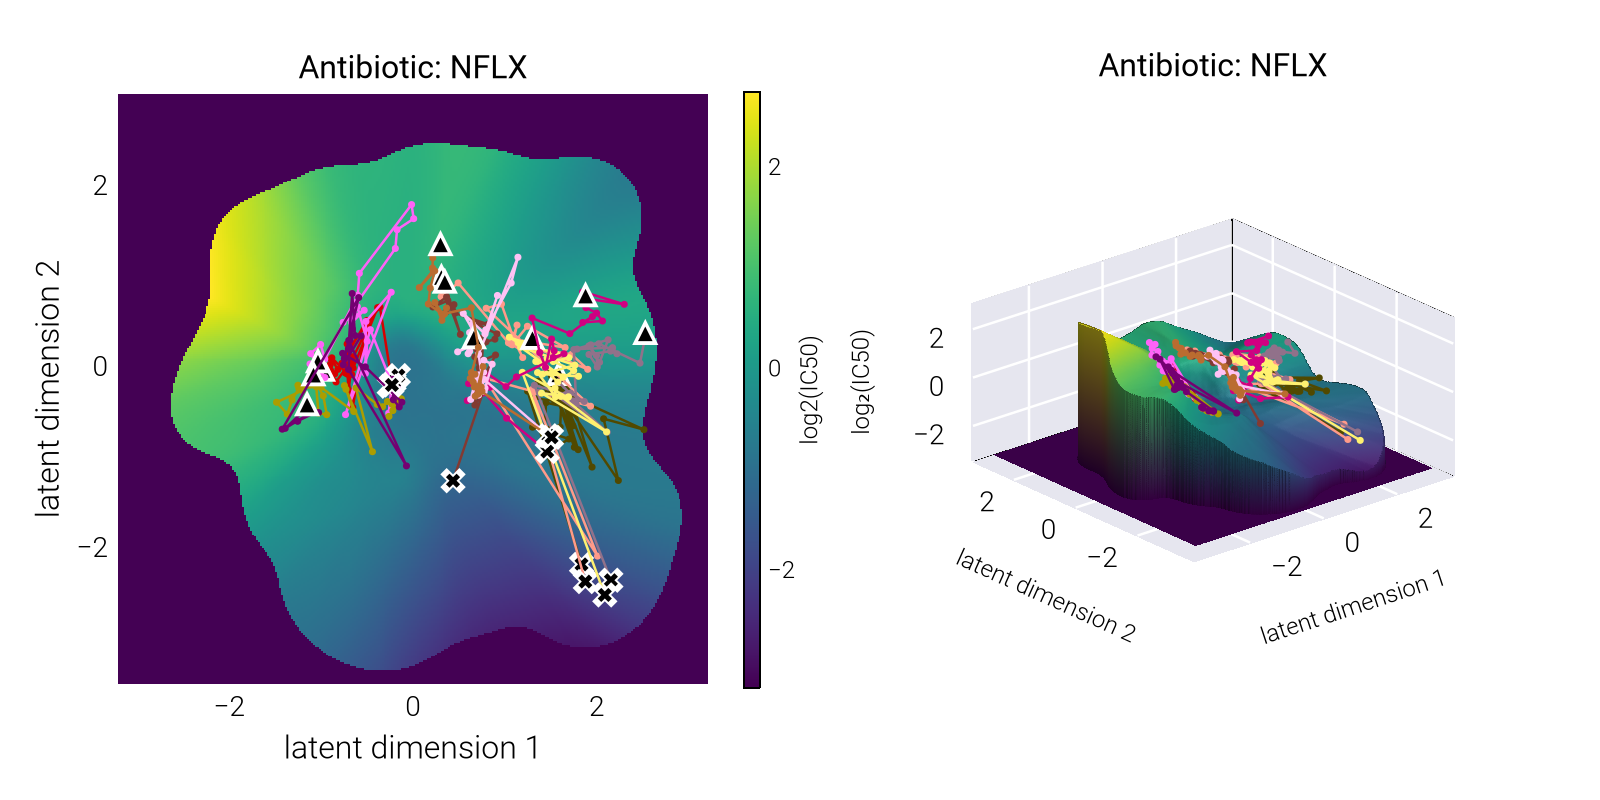

In [64]:
# Initialize figure
fig = Figure(size=(800, 400))

# Add global GridLayout to insert axis
gl = fig[1, 1] = GridLayout()

# Add 2D axis to plot
ax1 = Axis(
    gl[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    title="Antibiotic: $(antibiotic)",
    aspect=AxisAspect(1)
)

# Add 3D axis to plot
ax2 = Axis3(
    gl[1, 3],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    zlabel="log₂(IC50)",
    title="Antibiotic: $(antibiotic)",
    xlabelsize=12,
    ylabelsize=12,
    zlabelsize=12,
    aspect=(1, 1, 0.5),
    # azimuth=0.2π,
    # protrusions=(30, 10, 30, 20),
)
# Define fitness landscape
fit_landscape = dropdims(ic50_rhvae[:, :, drug.==antibiotic], dims=3)

# Mask fitness landscape
fit_landscape_masked = (mask .* minimum(fit_landscape)) .+
                       (fit_landscape .* .!mask)

# Plot heatmap of predicted resistance
hm = heatmap!(
    ax1,
    latent_range_z1,
    latent_range_z2,
    fit_landscape_masked,
    colormap=:viridis
)

# Add colorbar
cb = Colorbar(
    gl[1, 2],
    hm,
    size=8,
    label="log2(IC50)",
    labelsize=12,
    labelpadding=0.0,
    ticklabelsize=12,
    ticksvisible=false
)

# Plot surface of predicted resistance
surface!(
    ax2,
    latent_range_z1,
    latent_range_z2,
    fit_landscape_masked,
    colormap=:viridis
)

# Group data by strain
df_group = DF.groupby(df_antibiotic, :strain)

# Loop through groups
for (j, data) in enumerate(df_group)
    # Sort data by day
    data = DF.sort!(data, :day)
    # Add scatter plot to axis
    scatterlines!(
        ax1,
        data.z1,
        data.z2,
        markersize=5,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
    )

    # Add scatter plot to 3D axis
    scatterlines!(
        ax2,
        data.z1,
        data.z2,
        data.log2ic50,
        markersize=5,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j],
    )

    # Add first point 
    scatter!(
        ax1,
        [data.z1[1]],
        [data.z2[1]],
        color=:white,
        markersize=18,
        marker=:xcross
    )
    scatter!(
        ax1,
        [data.z1[1]],
        [data.z2[1]],
        color=:black,
        markersize=10,
        marker=:xcross
    )

    # Add last point
    scatter!(
        ax1,
        [data.z1[end]],
        [data.z2[end]],
        color=:white,
        markersize=18,
        marker=:utriangle
    )
    scatter!(
        ax1,
        [data.z1[end]],
        [data.z2[end]],
        color=:black,
        markersize=10,
        marker=:utriangle
    )
end

save("/Users/mrazo/Downloads/fig.png", fig)

fig